In [1]:
import os

exp_dir = f"results/"

os.makedirs(f"{exp_dir}/plots", exist_ok=True)

In [21]:
# latency cdfs data

import json
from collections import defaultdict
from datetime import datetime, timezone, timedelta

timings = defaultdict(lambda: defaultdict(list)) # mapping from config json to latency list

for config_dir in os.listdir(exp_dir):    
    if config_dir == "plots":
        continue
    print(config_dir)
    
    for repeat in os.listdir(f"{exp_dir}/{config_dir}"):
        # read in configuration.json file and parse
        with open(f"{exp_dir}/{config_dir}/{repeat}/configuration.json", "r") as config_file:
            config = config_file.read()
            config = json.dumps(json.loads(config))

        # read logs of docker-bench
        for bencher in os.listdir(f"{exp_dir}/{config_dir}/{repeat}/logs"):
            if bencher.startswith("bencher"):
                with open(f"{exp_dir}/{config_dir}/{repeat}/logs/{bencher}", "r") as log:
                    for line in log.readlines():
                        j = line
                        try:
                            output = json.loads(j)
                        except ValueError:
                            continue

                        start_secs = output["start"]["secs_since_epoch"]
                        start_nanos = output["start"]["nanos_since_epoch"]
                        start = datetime(1970, 1, 1, tzinfo=timezone.utc) + timedelta(seconds=start_secs,microseconds=start_nanos/1000)

                        end_secs = output["end"]["secs_since_epoch"]
                        end_nanos = output["end"]["nanos_since_epoch"]
                        end = datetime(1970, 1, 1, tzinfo=timezone.utc) + timedelta(seconds=end_secs,microseconds=end_nanos/1000)

                        latency = end - start
                        timings[config]["starts"].append(start)
                        timings[config]["ends"].append(end)
                        timings[config]["latencies"].append((latency / timedelta(microseconds=1))/1000.)
        print("datapoints:", len(timings[config]["latencies"]))
        
print("loaded", len(timings))

etcd-1nodes-2benchers
datapoints: 200000
recetcd-1nodes-2benchers
datapoints: 200000
recetcd-3nodes-2benchers
datapoints: 200000
etcd-5nodes-2benchers
datapoints: 200000
etcd-3nodes-2benchers
datapoints: 200000
recetcd-5nodes-2benchers
datapoints: 200000
loaded 6


In [22]:
import pandas as pd

l = {k:v["latencies"] for (k,v) in timings.items()}

series = pd.DataFrame(l)
series.describe()

,"{""image_name"": ""quay.io/coreos/etcd"", ""repeat"": 1, ""bench_type"": ""PutRange"", ""cluster_size"": 1, ""bencher_count"": 2, ""extra_args"": """", ""tmpfs"": false}","{""image_name"": ""jeffas/recetcd:latest"", ""repeat"": 1, ""bench_type"": ""PutRange"", ""cluster_size"": 1, ""bencher_count"": 2, ""extra_args"": """", ""tmpfs"": false}","{""image_name"": ""jeffas/recetcd:latest"", ""repeat"": 1, ""bench_type"": ""PutRange"", ""cluster_size"": 3, ""bencher_count"": 2, ""extra_args"": """", ""tmpfs"": false}","{""image_name"": ""quay.io/coreos/etcd"", ""repeat"": 1, ""bench_type"": ""PutRange"", ""cluster_size"": 5, ""bencher_count"": 2, ""extra_args"": """", ""tmpfs"": false}","{""image_name"": ""quay.io/coreos/etcd"", ""repeat"": 1, ""bench_type"": ""PutRange"", ""cluster_size"": 3, ""bencher_count"": 2, ""extra_args"": """", ""tmpfs"": false}","{""image_name"": ""jeffas/recetcd:latest"", ""repeat"": 1, ""bench_type"": ""PutRange"", ""cluster_size"": 5, ""bencher_count"": 2, ""extra_args"": """", ""tmpfs"": false}"
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,36.783619,30.190131,11.296228,156.536693,118.266644,7.915464
std,28.493905,4.127255,11.260277,53.799626,38.964972,9.765432
min,4.094000,2.590000,0.545000,15.991000,15.708000,0.522000
25%,16.418000,27.426000,1.544000,119.019000,86.968000,1.263000
50%,24.220000,30.252000,5.980000,153.593000,122.696000,2.345000
75%,40.222000,32.445000,20.298000,193.852250,145.601000,12.328000
max,158.921000,112.969000,73.347000,436.469000,279.966000,70.571000


In [10]:
# latency scatter plots

import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": 12,
})

def plot_scatter(bench_type, cluster_size):
    f = plt.figure()
    f.set_figwidth(6.4 * 1)
    f.set_figheight(4.8 * 1)

    for (k, v) in timings.items():
        config = json.loads(k)
        if config["bench_type"] != bench_type:
            continue

        if config["cluster_size"] == cluster_size:
            if config["image_name"] == "quay.io/coreos/etcd":
                image = "etcd"
            elif config["image_name"] == "jeffas/eckd":
                image = "eckd"
            elif "jeffas/recetcd" in config["image_name"]:
                image = "recetcd"
            else:
                print("unmatched image name:", config["image_name"])
                        
            starts = v["starts"]
            start = starts[0]
            starts = [(s - start) / timedelta(seconds=1) for s in starts]
            latencies = v["latencies"]

            plt.scatter(starts, latencies, label=f"{image} x{cluster_size}")

    plt.grid()
    plt.title(f"Latency Scatter ({bench_type})")
    plt.xlabel("Time from start (s)")
    plt.ylabel("Request duration (ms)")
    plt.legend()

    lower_bench_type = bench_type.lower()
    plt.savefig(f"{exp_dir}/plots/latency-scatter-{lower_bench_type}.pdf")

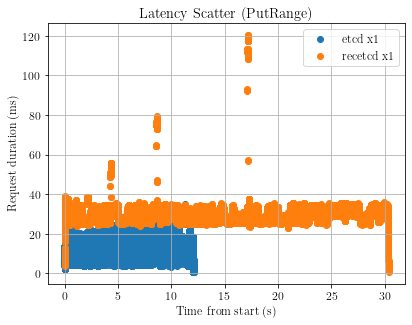

In [5]:
plot_scatter("PutRange", 1)

In [ ]:
plot_scatter("PutSingle", 1)

In [ ]:
plot_scatter("PutRandom", 1)

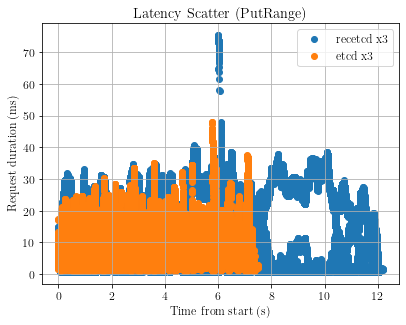

In [11]:
plot_scatter("PutRange", 3)

In [ ]:
plot_scatter("PutSingle", 3)

In [ ]:
plot_scatter("PutRandom", 3)

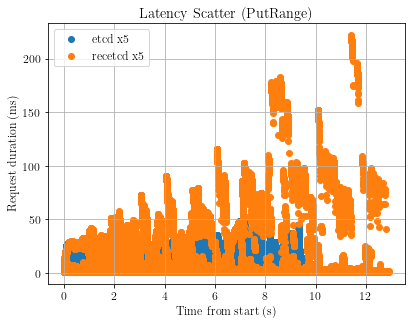

In [12]:
plot_scatter("PutRange", 5)

In [ ]:
plot_scatter("PutSingle", 5)

In [ ]:
plot_scatter("PutRandom", 5)

In [23]:
# latency cdfs plots

import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": 12,
})

def plot_cdf(bench_type, cluster_size):
    f = plt.figure()
    scale = 2
    f.set_figwidth(6.4 * scale)
    f.set_figheight(4.8 * scale)
    
    grouped_latencies = defaultdict(list)     

    for (k, v) in timings.items():
        config = json.loads(k)
        if config["bench_type"] != bench_type:
            continue

        if config["cluster_size"] == cluster_size:
            latencies = v["latencies"]
            
            del config["repeat"]
            k = json.dumps(config)
            grouped_latencies[k] += latencies
            
    for (k, v) in grouped_latencies.items():
        config = json.loads(k)
        if config["image_name"] == "quay.io/coreos/etcd":
            image = "etcd"
        elif config["image_name"] == "jeffas/eckd":
            image = "eckd"
        elif "jeffas/recetcd" in config["image_name"]:
            image = "recetcd"
        else:
            print("unmatched image name:", config["image_name"])
        
        latencies = v
        latencies.sort()
        size = len(latencies)
        ys = np.array(range(size))/ float(size)
        
        plt.plot(latencies, ys, label=f"{image} x{cluster_size}")

    plt.grid()
    plt.title(f"Latency CDF ({bench_type})")
    plt.xlabel("Request duration (ms)")
    plt.ylabel("Probability")
    plt.legend()

    lower_bench_type = bench_type.lower()
    plt.savefig(f"{exp_dir}/plots/latency-cdf-{lower_bench_type}.pdf")

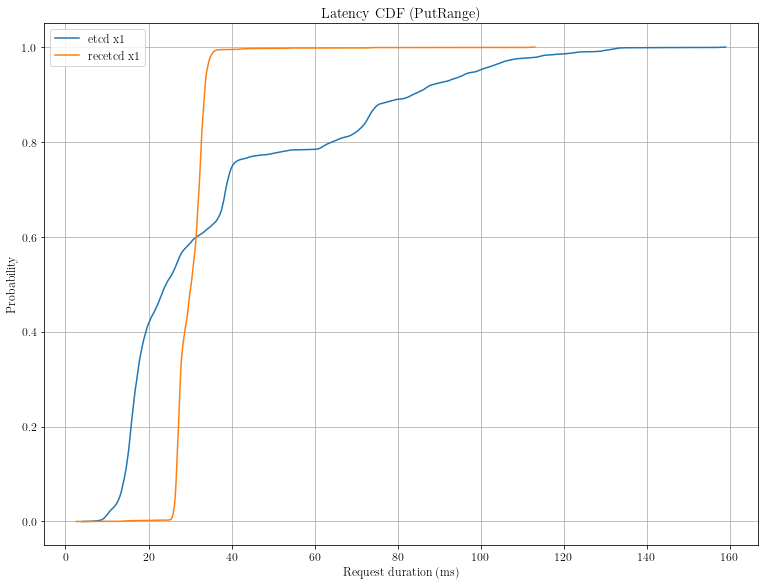

In [24]:
plot_cdf("PutRange", 1)

In [ ]:
plot_cdf("PutSingle", 1)

In [ ]:
plot_cdf("PutRandom", 1)

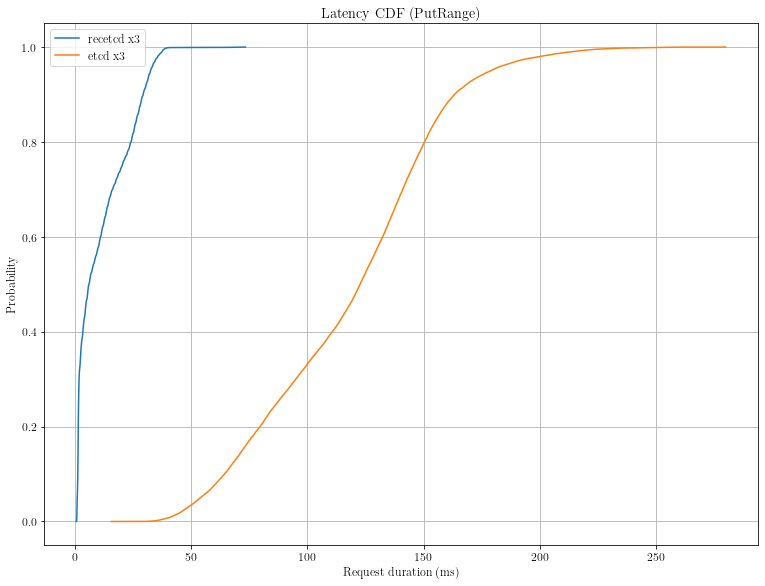

In [25]:
plot_cdf("PutRange", 3)

In [ ]:
plot_cdf("PutSingle", 3)

In [ ]:
plot_cdf("PutRandom", 3)

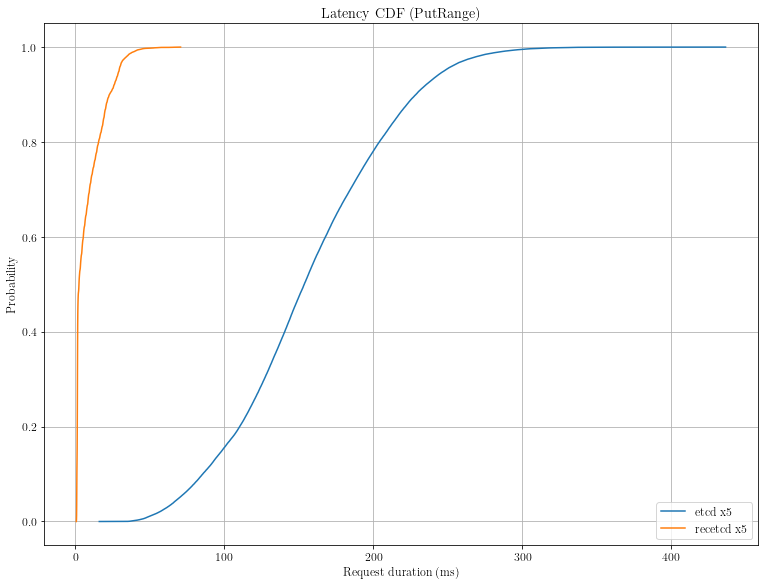

In [26]:
plot_cdf("PutRange", 5)

In [ ]:
plot_cdf("PutSingle", 5)

In [ ]:
plot_cdf("PutRandom", 5)

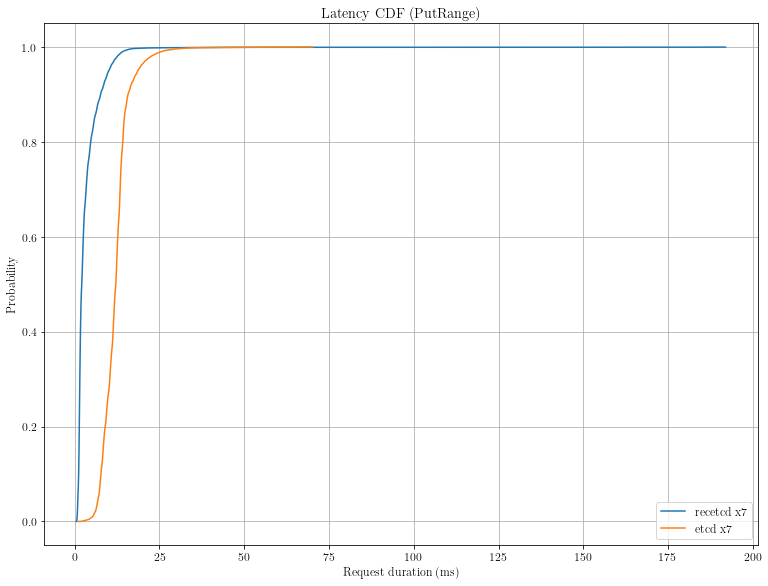

In [54]:
plot_cdf("PutRange", 7)

In [17]:
# plot percentile latencies of datastores at differing cluster sizes

import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": 12,
})

def plot_latency_percentiles(bench_type, percentiles=[50]):
    f = plt.figure()
    f.set_figwidth(6.4 * 2)
    f.set_figheight(4.8 * 2)
    
    ls = {} # mapping from legend item to list of datapoints

    for (k, v) in timings.items():
        config = json.loads(k)
        cluster_size = config["cluster_size"]
        if config["image_name"] == "quay.io/coreos/etcd":
            image = "etcd"
        elif config["image_name"] == "jeffas/eckd":
            image = "eckd"
        elif "jeffas/recetcd" in config["image_name"]:
            image = "recetcd"
        else:
            print("unmatched image name:", config["image_name"])
            
        latencies = v["latencies"]
        
        if image not in ls:
            ls[image] = {}
        if cluster_size not in ls[image]:
            ls[image][cluster_size] = []
        ls[image][cluster_size] += latencies
            
    
    meds = defaultdict(list)
    for (image, sizes) in ls.items():
        for (size, latencies) in sizes.items():
            ps = np.percentile(latencies, percentiles)
            for (i, p) in enumerate(ps):
                i = f"{image}-{percentiles[i]}"
                meds[i].append((size, p))
    xs = []      
    for (image, axes) in meds.items():
        axes.sort(key=lambda t: t[0])
        xs, ys = [[ i for i, j in axes ], [ j for i, j in axes ]]
        plt.plot(xs, ys, label=f"{image}")

    plt.grid()
    plt.title(f"Latency Percentiles ({bench_type})")
    plt.ylabel("Median Request duration (ms)")
    plt.xlabel("Cluster size")
    plt.xticks(xs)
    plt.legend()

    lower_bench_type = bench_type.lower()
    plt.savefig(f"{exp_dir}/plots/latency-percentiles-{lower_bench_type}.pdf")

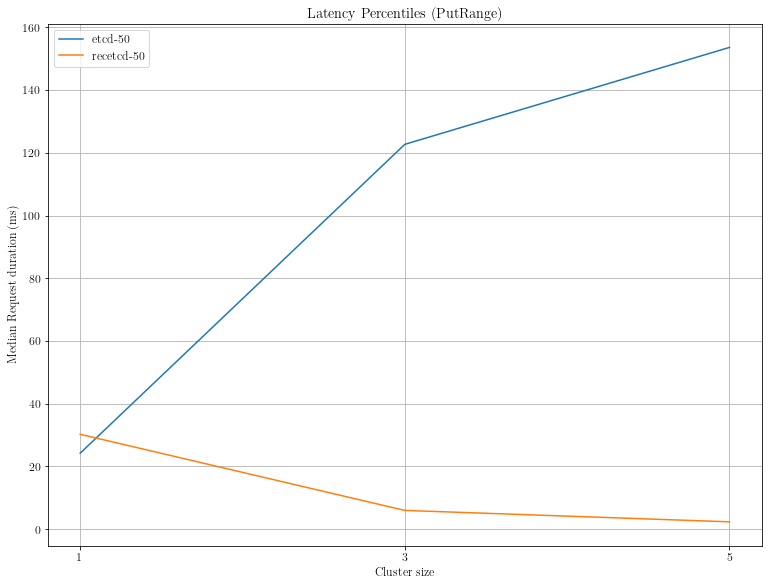

In [27]:
plot_latency_percentiles("PutRange", percentiles = [50])

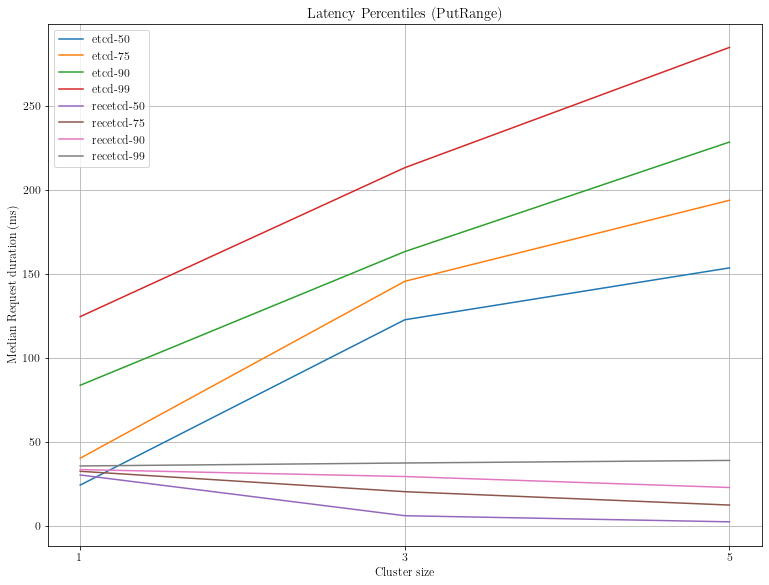

In [28]:
plot_latency_percentiles("PutRange", percentiles = [50, 75, 90, 99])

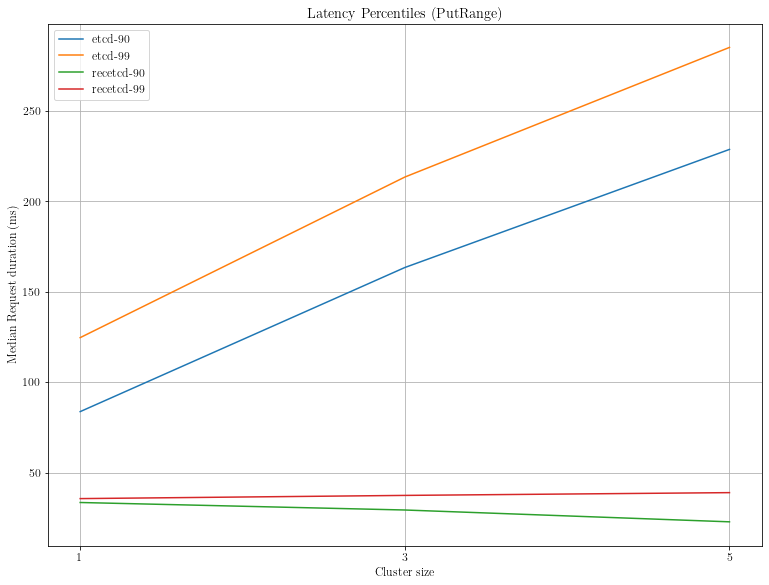

In [29]:
plot_latency_percentiles("PutRange", percentiles = [90, 99])

In [ ]:
# get cpu and mem data

import json
from collections import defaultdict
from datetime import datetime, timezone, timedelta

cpu_usage = {} # mapping from config json to cpu usage list
mem_usage = {} # mapping from config json to mem usage list

for config in config_dirs:
    print("processing", config)
    c = json.dumps(json.loads("".join(open(f"{exp_dir}/{config}/configuration.json").readlines())))

    for repeat in os.listdir(f"{exp_dir}/{config}"):
        if repeat.startswith("repeat"):
            with open(f"{exp_dir}/{config}/{repeat}/logs/docker-bench.log", "r") as log:
                for line in log.readlines():
                    j = line.split()[1]
                    try:
                        output = json.loads(j)
                    except ValueError:
                        continue

                    start_secs = output["start"]["secs_since_epoch"]
                    start_nanos = output["start"]["nanos_since_epoch"]
                    start = datetime(1970, 1, 1) + timedelta(seconds=start_secs,microseconds=start_nanos/1000)
                    break
                    
            # read metrics of node*
            with open(f"{exp_dir}/{config}/{repeat}/metrics/docker-node1.stat", "r") as stats:
                times = []
                cpus = []
                mems = []
                for line in stats.readlines():
                    sp = line.split()
                    
                    dt = sp[0]
                    dt = dt.replace("+00:00","")
                    dot = dt.find(".")
        
                    dt = datetime.fromisoformat(dt[:dot+7])
             
                    times.append(dt-start)
                    j = sp[1]
                    
                    output = json.loads(j)
                    
                    # from https://github.com/docker/cli/blob/bf4a96e5640f86860e68622d2498039d86bf5714/cli/command/container/stats_helpers.go#L166
                    cpu_percent = 0
                    cpu_delta = output["cpu_stats"]["cpu_usage"]["total_usage"] - output["precpu_stats"]["cpu_usage"]["total_usage"]
                    system_delta = output["cpu_stats"]["system_cpu_usage"] - (output["precpu_stats"]["system_cpu_usage"] or 0)
                    online_cpus = output["cpu_stats"]["online_cpus"]
                    if online_cpus == 0:
                        print("no cpus!!")
                    if system_delta > 0 and cpu_delta > 0:
                        cpu_percent = (float(cpu_delta) / float(system_delta)) * float(online_cpus) * 100.0
                    cpus.append(cpu_percent)
                    
                    
                    mem = output["memory_stats"]["usage"]
                    mems.append(mem)
                
                cpu_usage[c] = (times, cpus)
                mem_usage[c] = (times, mems)

In [ ]:
# cpu usage plots

import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": 12,
})

def plot_cpu(bench_type, cluster_size):

    f = plt.figure()
    f.set_figwidth(6.4 * 1)
    f.set_figheight(4.8 * 1)

    for (k, v) in cpu_usage.items():
        config = json.loads(k)
        if config["bench_type"] != bench_type:
            continue

        if config["cluster_size"] == cluster_size:
            if config["image_name"] == "quay.io/coreos/etcd":
                image = "etcd"
            elif config["image_name"] == "jeffas/eckd":
                image = "eckd"
            elif config["image_name"] == "jeffas/recetcd":
                image = "recetcd"
            else:
                print("unmatched image name:", config["image_name"])

            xs = [x.total_seconds() for x in v[0]]
            ys = v[1]

            plt.plot(xs, ys, label=f"{image} x{cluster_size}")

    plt.grid()
    plt.title(f"CPU Usage ({bench_type})")
    plt.xlabel("Time since start (s)")
    plt.ylabel("CPU usage (\%)")
    plt.legend()

    lower_bench_type = bench_type.lower()
    plt.savefig(f"{exp_dir}/plots/cpu-usage-{lower_bench_type}.pdf")

In [ ]:
plot_cpu("PutRange", 1)

In [ ]:
plot_cpu("PutSingle", 1)

In [ ]:
plot_cpu("PutRandom", 1)

In [ ]:
plot_cpu("PutRange", 3)

In [ ]:
plot_cpu("PutSingle", 3)

In [ ]:
plot_cpu("PutRandom", 3)

In [ ]:
plot_cpu("PutRange", 5)

In [ ]:
plot_cpu("PutSingle", 5)

In [ ]:
plot_cpu("PutRandom", 5)

In [ ]:
# mem usage plots

import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": 12,
})

def plot_mem(bench_type, cluster_size):
    f = plt.figure()
    f.set_figwidth(6.4 * 1)
    f.set_figheight(4.8 * 1)

    for (k, v) in mem_usage.items():
        config = json.loads(k)
        if config["bench_type"] != bench_type:
            continue

        if config["cluster_size"] == cluster_size:
            if config["image_name"] == "quay.io/coreos/etcd":
                image = "etcd"
            elif config["image_name"] == "jeffas/eckd":
                image = "eckd"
            elif config["image_name"] == "jeffas/recetcd":
                image = "recetcd"
            else:
                print("unmatched image name:", config["image_name"])

            xs = [x.total_seconds() for x in v[0]]
            ys = np.array(v[1]) / 1_000_000

            plt.plot(xs, ys, label=f"{image} x{cluster_size}")

    plt.grid()
    plt.title(f"Memory Usage ({bench_type})")
    plt.xlabel("Time since start (s)")
    plt.ylabel("Memory usage (MB)")
    plt.legend()

    lower_bench_type = bench_type.lower()
    plt.savefig(f"{exp_dir}/plots/mem-usage-{lower_bench_type}.pdf")

In [ ]:
plot_mem("PutRange", 1)

In [ ]:
plot_mem("PutSingle", 1)

In [ ]:
plot_mem("PutRandom", 1)

In [ ]:
plot_mem("PutRange", 3)

In [ ]:
plot_mem("PutSingle", 3)

In [ ]:
plot_mem("PutRandom", 3)

In [ ]:
plot_mem("PutRange", 5)

In [ ]:
plot_mem("PutSingle", 5)

In [ ]:
plot_mem("PutRandom", 5)